In [2]:
import pandas as pd
import requests
pd.set_option('display.max_columns', None) # allows viewing of all columns in a wide DataFrame
import time
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [18]:
data = pd.read_excel('nba_player_data.xlsx')

In [19]:
data.shape

(8048, 30)

## Data Cleaning & Analysis Preparation

In [20]:
data.isna().sum()

Year           0
Season_type    0
PLAYER_ID      0
RANK           0
PLAYER         0
TEAM_ID        0
TEAM           0
GP             0
MIN            0
FGM            0
FGA            0
FG_PCT         0
FG3M           0
FG3A           0
FG3_PCT        0
FTM            0
FTA            0
FT_PCT         0
OREB           0
DREB           0
REB            0
AST            0
STL            0
BLK            0
TOV            0
PF             0
PTS            0
EFF            0
AST_TOV        0
STL_TOV        0
dtype: int64

In [21]:
# Remove columns that are not relevant or don't provide useful information

data.drop(columns=['RANK', 'EFF'], inplace=True)

In [22]:
# Add column to make start year value easily accessible

data['season_start_year'] = data['Year'].str[:4].astype(int)

In [23]:
# Check for team name changes within the last 10 years

data.TEAM.nunique()

# Change all instances of 'NOH' (New Orleans Hornets) and 'NOP' (New Orleans Pelicans) to a standardized 'NO' (New Orleans)

data['TEAM'].replace(to_replace=['NOP','NOH'], value='NO', inplace=True)

# Clean up formatting of Regular Season value ('Regular%20Season')

data['Season_type'].replace('Regular%20Season', 'Regular Season', inplace = True)

In [24]:
# Separating large DataFrame into one for regular season and one for playoffs

rs_df = data[data['Season_type']=='Regular Season']
po_df = data[data['Season_type']=='Playoffs']

In [25]:
# Remove percentage statistics so we can convert to per minute

total_cols = ['MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 
              'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

## Player Statistics Correlations

In [26]:
# Group the data for the statistics we want to look at by player and year

data_per_min = data.groupby(['PLAYER', 'PLAYER_ID', 'Year'])[total_cols].sum().reset_index()

In [27]:
# Convert statistics to per min statistics

for col in data_per_min.columns[4:]:
    data_per_min[col] = data_per_min[col] / data_per_min['MIN']
    
# Re-add percentage statistics
    
data_per_min['FG%'] = data_per_min['FGM']/data_per_min['FGA']
data_per_min['3PT%'] = data_per_min['FG3M']/data_per_min['FG3A']
data_per_min['FT%'] = data_per_min['FTM']/data_per_min['FTA']
data_per_min['FG3A%'] = data_per_min['FG3A']/data_per_min['FGA']
data_per_min['PTS/FGA'] = data_per_min['PTS']/data_per_min['FGA']
data_per_min['FG3M/FGM'] = data_per_min['FG3M']/data_per_min['FGM']
data_per_min['FTA/FGA'] = data_per_min['FTA']/data_per_min['FGA']
data_per_min['TRU%'] = 0.5*data_per_min['PTS']/(data_per_min['FGA']+0.475*data_per_min['FTA'])
data_per_min['AST/TOV'] = data_per_min['AST']/data_per_min['TOV']

,PLAYER,PLAYER_ID,Year,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,FG%,3PT%,FT%,FG3A%,PTS/FGA,FG3M/FGM,FTA/FGA,TRU%,AST/TOV
0,A.J. Lawson,1630639,2022-23,108,0.203704,0.407407,0.092593,0.231481,0.018519,0.074074,0.055556,0.138889,0.194444,0.018519,0.018519,0.000000,0.027778,0.101852,0.518519,0.500000,0.400000,0.250000,0.568182,1.272727,0.454545,0.181818,0.585774,0.666667
1,AJ Green,1631260,2022-23,345,0.153623,0.362319,0.127536,0.304348,0.011594,0.011594,0.017391,0.113043,0.130435,0.063768,0.017391,0.000000,0.026087,0.089855,0.446377,0.424000,0.419048,1.000000,0.840000,1.232000,0.830189,0.032000,0.606777,2.444444
2,AJ Griffin,1631100,2022-23,1401,0.177016,0.380443,0.072091,0.184868,0.029979,0.033547,0.026410,0.082798,0.109208,0.052106,0.029979,0.008565,0.029979,0.062099,0.456103,0.465291,0.389961,0.893617,0.485929,1.198874,0.407258,0.088180,0.575339,1.738095
3,AJ Hammons,1627773,2016-17,163,0.104294,0.257669,0.030675,0.061350,0.055215,0.122699,0.049080,0.171779,0.220859,0.024540,0.006135,0.079755,0.061350,0.128834,0.294479,0.404762,0.500000,0.450000,0.238095,1.142857,0.294118,0.476190,0.466019,0.400000
4,AJ Price,201985,2012-13,1278,0.125978,0.323161,0.054773,0.156495,0.038341,0.048513,0.015649,0.073552,0.089202,0.160407,0.025822,0.002347,0.050078,0.057121,0.345070,0.389831,0.350000,0.790323,0.484262,1.067797,0.434783,0.150121,0.498361,3.203125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5691,Zion Williamson,1629627,2020-21,2026,0.312932,0.511846,0.004936,0.016782,0.182132,0.261106,0.082428,0.135242,0.217670,0.111550,0.028134,0.019250,0.082428,0.066634,0.812932,0.611379,0.294118,0.697543,0.032787,1.588235,0.015773,0.510125,0.639227,1.353293
5692,Zion Williamson,1629627,2022-23,956,0.298117,0.490586,0.007322,0.019874,0.185146,0.259414,0.060669,0.150628,0.211297,0.139121,0.033473,0.016736,0.103556,0.067992,0.788703,0.607676,0.368421,0.713710,0.040512,1.607676,0.024561,0.528785,0.642468,1.343434
5693,Zoran Dragic,204054,2014-15,75,0.146667,0.400000,0.040000,0.186667,0.040000,0.066667,0.066667,0.040000,0.106667,0.066667,0.026667,0.000000,0.066667,0.080000,0.373333,0.366667,0.214286,0.600000,0.466667,0.933333,0.272727,0.166667,0.432432,1.000000
5694,Zylan Cheatham,1629597,2019-20,51,0.117647,0.176471,0.000000,0.019608,0.000000,0.000000,0.058824,0.117647,0.176471,0.058824,0.019608,0.019608,0.078431,0.196078,0.235294,0.666667,0.000000,NaN,0.111111,1.333333,0.000000,0.000000,0.666667,0.750000


In [29]:
# Remove players who barely played at all so our data is not skewed

data_per_min = data_per_min[data_per_min['MIN']>=70]

# Remove player ID column
data_per_min.drop(columns='PLAYER_ID', inplace=True)

/var/folders/5x/f9p4l0js21l4hxf7n7y4247m0000gn/T/ipykernel_93368/1252637717.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



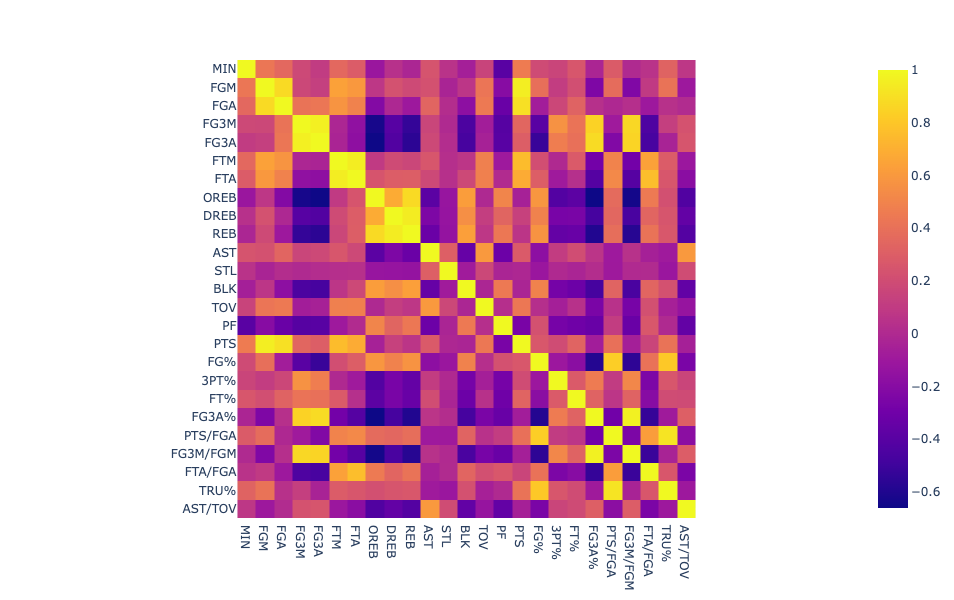

In [31]:
# Create correlation plot

fig = px.imshow(data_per_min.corr())
fig.update_layout(
    autosize=False,
    width=800,  # Adjust the width as desired
    height=600,  # Adjust the height as desired
)
fig.show()

## Players Minutes Distribution (Regular Season vs Playoffs)

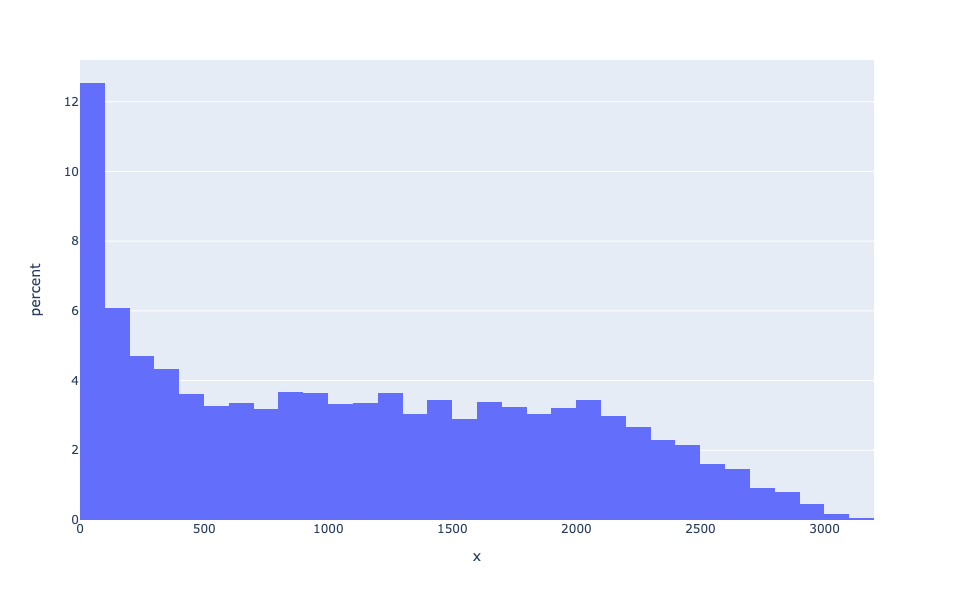

In [34]:
fig = px.histogram(x=rs_df['MIN'], histnorm='percent')
fig.update_layout(
    autosize=False,
    width=800,  # Adjust the width as desired
    height=600,  # Adjust the height as desired
)
fig.show()

In [41]:
# Create function to ensure that we don't include outliers who barely played to skew the distribution

def hist_data(df=rs_df, min_MIN=0, min_GP=0):
    return df.loc[(df['MIN']>=min_MIN) & (df['GP']>=min_GP), 'MIN']/\
    df.loc[(df['MIN']>=min_MIN) & (df['GP']>=min_GP), 'GP']

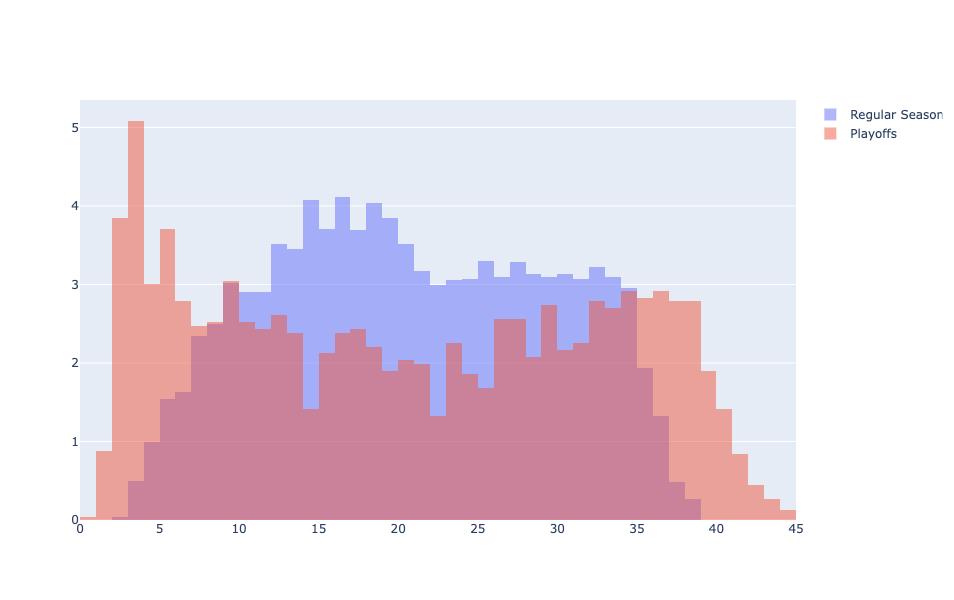

In [42]:
# Create overlapping histograms to compare distribution of playoff minutes vs distribution of regular season minutes

fig = go.Figure()
fig.add_trace(go.Histogram(x=hist_data(rs_df, 50, 5), histnorm='percent', name='Regular Season', xbins={'start':0,'end':46,'size':1}))
fig.add_trace(go.Histogram(x=hist_data(po_df, 5, 1), histnorm='percent', name='Playoffs', xbins={'start':0,'end':46,'size':1}))
fig.update_layout(
    barmode='overlay',
    autosize=False,
    width=800,  # Adjust the width as desired
    height=600,  # Adjust the height as desired
)
fig.update_traces(opacity=0.5)
fig.show()

In [46]:
# Calculate what percentage of the regular season distribution falls between 10 and 34

((hist_data(rs_df, 50, 5)>=10) & (hist_data(rs_df, 50, 5)<=34)).mean()

0.8052247406838263

In [47]:
# # Calculate what percentage of the playoffs distribution falls between 10 and 34


((hist_data(po_df, 5, 1)>=10) & (hist_data(po_df, 5, 1)<=34)).mean()

0.5395492708793637

## Data Trends in the Last 10 Years

In [53]:
# Group the data totals by year

trends_df = data.groupby('season_start_year')[total_cols].sum().reset_index()

In [54]:
# Estimate the number of possessions

trends_df['POSS'] = trends_df['FGA']-trends_df['OREB']+trends_df['TOV']+0.44*trends_df['FTA']

In [55]:
# Rearrange column order to insert Possessions closer to the left side of the table

trends_df = trends_df[list(trends_df.columns[0:2])+['POSS']+list(trends_df.columns[2:-1])]

,season_start_year,MIN,POSS,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,2012,635884,248201.92,97235,215105,18808,52569,44125,58618,29237,81362,110599,57694,20376,13444,36542,52548,257403
1,2013,638373,254032.80,99251,218411,20480,56952,47219,62420,28669,83812,112481,57657,20156,12369,36826,54839,266201
2,2014,634546,253004.12,98251,219265,20724,59276,45098,60248,28566,85231,113797,57727,20261,12665,35796,53272,262324
3,2015,636391,258064.80,100351,222344,22524,63673,46516,61520,27426,87611,115037,58251,20562,13046,36078,53478,269742
4,2016,632482,258443.80,102147,223333,25408,71018,46806,60620,26470,87173,113643,59162,20143,12409,34908,52232,276508
5,2017,633425,260904.52,103729,225523,27530,76245,43721,57008,25397,88678,114075,60739,20181,12636,35695,52238,278709
6,2018,634231,268739.84,107374,233717,29817,84143,46671,60811,27128,91360,118488,64257,19940,12984,35394,55063,291236
7,2019,552262,234384.64,92997,202223,28032,78279,40949,52906,22802,79318,102120,55445,17368,11085,31685,47615,254975
8,2020,562518,235759.48,95849,205754,29549,80653,39624,50917,22918,80151,103069,57311,17491,11272,30520,45152,260871
9,2021,635572,264004.96,106569,231293,32733,92552,44740,57709,27052,89602,116654,64618,20006,12387,34372,52038,290611


In [56]:
# Calculate percentage statistics with the totals for each year

trends_df['FG%'] = trends_df['FGM']/trends_df['FGA']
trends_df['3PT%'] = trends_df['FG3M']/trends_df['FG3A']
trends_df['FT%'] = trends_df['FTM']/trends_df['FTA']
trends_df['AST%'] = trends_df['AST']/trends_df['FGM']
trends_df['FG3A%'] = trends_df['FG3A']/trends_df['FGA']
trends_df['PTS/FGA'] = trends_df['PTS']/trends_df['FGA']
trends_df['FG3M/FGM'] = trends_df['FG3M']/trends_df['FGM']
trends_df['FTA/FGA'] = trends_df['FTA']/trends_df['FGA']
trends_df['TRU%'] = 0.5*trends_df['PTS']/(trends_df['FGA']+0.475*trends_df['FTA'])
trends_df['AST/TOV'] = trends_df['AST']/trends_df['TOV']

In [58]:
# Create a copy of the trends DataFrame so we can manipulate the new one per 48 minutes

trends_per48_df = trends_df.copy()

In [61]:
# Adjust the data totals per 48 minutes per team

for col in trends_per48_df.columns[2:18]:
    trends_per48_df[col] = (trends_per48_df[col]/trends_per48_df['MIN'])*48*5

In [63]:
# Remove unnecessary column

trends_per48_df.drop(columns ='MIN', inplace=True)

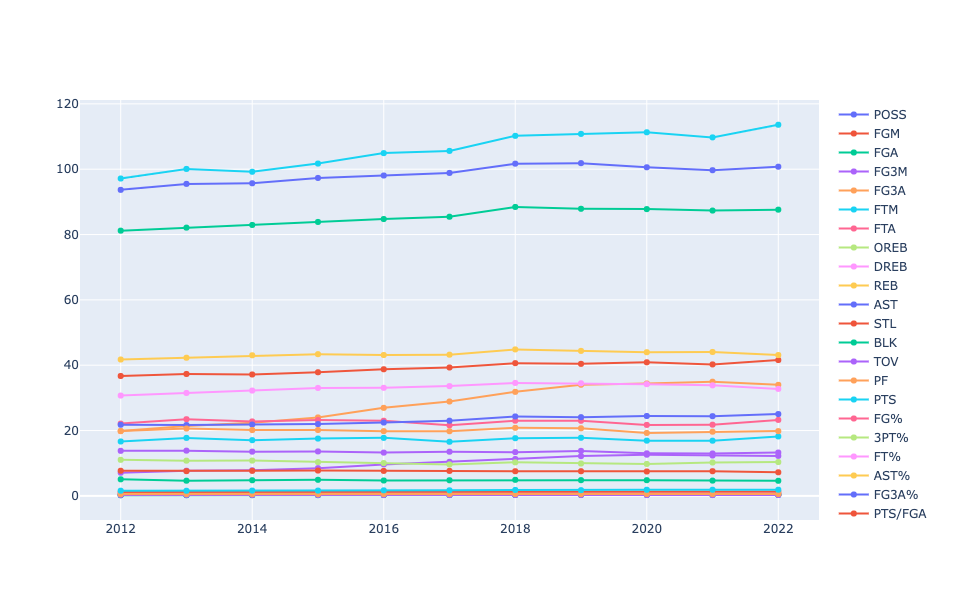

In [65]:
# Create scatterplot showing the changes over the last 10 seasons of all the statistics

fig = go.Figure()
for col in trends_per48_df.columns[1:]:
    fig.add_trace(go.Scatter(x=trends_per48_df['season_start_year'],
                            y=trends_per48_df[col], name=col))

fig.update_layout(
    autosize=False,
    width=800,  # Adjust the width as desired
    height=600,  # Adjust the height as desired
)
fig.show()

## Analyzing Change in Statistics from Regular Season to Playoffs

In [102]:
# Create a separate DataFrame grouped by year for regular season and playoffs, respectively

rs_change_df=rs_df.groupby('season_start_year')[total_cols].sum().reset_index()
po_change_df=po_df.groupby('season_start_year')[total_cols].sum().reset_index()

In [103]:
# Calculating Possessions, Possessions per 48 minutes, and percentage statistics for both of the new DataFrames

for i in [rs_change_df, po_change_df]:
    i['POSS'] = i['FGA']-i['OREB']+i['TOV']+0.44*i['FTA']
    i['POSS_per_48'] = (i['POSS']/i['MIN'])*48*5
    
    i['FG%'] = i['FGM']/i['FGA']
    i['3PT%'] = i['FG3M']/i['FG3A']
    i['FT%'] = i['FTM']/i['FTA']
    i['AST%'] = i['AST']/i['FGM']
    i['FG3A%'] = i['FG3A']/i['FGA']
    i['PTS/FGA'] = i['PTS']/i['FGA']
    i['FG3M/FGM'] = i['FG3M']/i['FGM']
    i['FTA/FGA'] = i['FTA']/i['FGA']
    i['TRU%'] = 0.5*i['PTS']/(i['FGA']+0.475*i['FTA'])
    i['AST/TOV'] = i['AST']/i['TOV']
    
    # Calculating per 100 possessions statistics for each totals column
    for col in total_cols:
        i[col] = 100*i[col]/i['POSS']
        
    # Drop unnecessary columns
    i.drop(columns=['MIN','POSS'], inplace=True)

In [104]:
# Create DataFrame for the percent change in all the statistics from regular season to playoffs

change_df = round(100*(po_change_df-rs_change_df)/rs_change_df, 3)
change_df['season_start_year'] = list(range(2012, 2023))

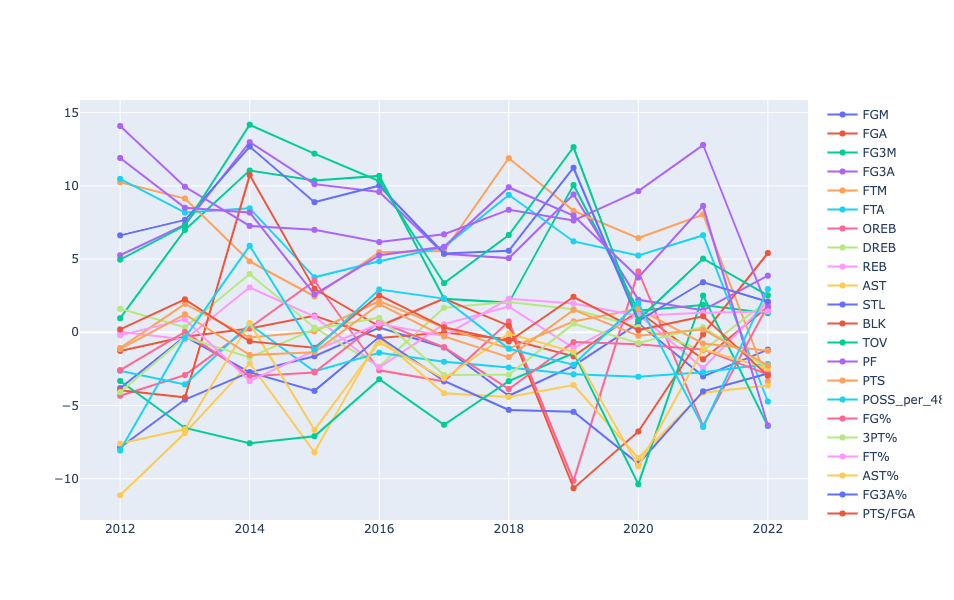

In [105]:
# Create a scatterplot to show the percent change in each of the statistics from regular season to playoffs over the last 10 seasons

fig = go.Figure()
for col in change_df.columns[1:]:
    fig.add_trace(go.Scatter(x=change_df['season_start_year'],
                            y=change_df[col], name=col))

fig.update_layout(
    autosize=False,
    width=800,  # Adjust the width as desired
    height=600,  # Adjust the height as desired
)
fig.show()